# RedditScrapper2

In [71]:
import numpy as np 
import pandas as pd
import praw 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import networkx as nx 
from prawcore.exceptions import Forbidden

#praw and reddit api
user_agent = 'MaterialRecording160'
reddit = praw.Reddit(client_id='vlH31uoAfN_ZjJOxsHXjlA',
                     client_secret='Tvcj9Br6fHw-t6NwhgqNW5MULi0-2w',
                     user_agent=user_agent)

In [123]:
#functions

def get_posts(subred_name, n):
    subreddit = reddit.subreddit(subred_name)
    posts_info = [] 
    
    for subm in subreddit.top(limit=n):
        
        subred_info = []
        subred_info.append(subm.id)  
        subred_info.append(str(subm.author)) 
        subred_info.append(subm.score)
        subred_info.append(subm.subreddit)
        posts_info.append(subred_info)
    
    sorted_info = sorted(posts_info, key=lambda x: x[1], reverse = True)
    posts_df = pd.DataFrame(sorted_info, columns = ['id','author', 'score', 'subreddit'])
    return posts_df

def get_subreddit_top_authors(subreddit, n_posts = 2000, graph = False):
    prog_df = get_posts(subreddit, n_posts)
    freq_authors = prog_df[prog_df.duplicated(['author'], keep = False)]
    freq_authors = freq_authors[freq_authors.author != 'None']
    
    if graph == True:
        plt.figure(figsize=(10, 5))
        ax = freq_authors['author'].value_counts().plot(kind='bar',title='Distribution of author/users and their posts')
        ax.set_xlabel("Users")
        ax.set_ylabel("Number of posts")
        plt.show()
    
    return freq_authors

def get_users_post(username, number = 5):
    user = reddit.redditor(username)
    user_comments_info = []
    
    for comment in user.comments.new(limit = number):
        user_comments_info.append(str(comment.id))
        user_comments_info.append(str(username))
        user_comments_info.append(int(comment.score))
        user_comments_info.append(str(comment.subreddit.display_name))
    
    df = pd.DataFrame([(user_comments_info[i], user_comments_info[i+2], user_comments_info[i+1], 
                        user_comments_info[i+3]) for i in range(0, len(user_comments_info), 4)], 
                      columns=['id', 'score', 'user_name', 'subreddit_name'])
    
    return df

def scrap_celebrities(user_name_list, number = 5):
    df = pd.DataFrame()
    df = df.fillna(0)

    for author in user_name_list:
        try:
            temp = get_users_post(author, number)
            print(temp)
            df = pd.concat([df, temp])
        except Forbidden:
            print(f'{author} account deleted or banned')
            
    
    return df

def graph_visual(g, no_it = 50, k_val = 0.2):
    figure(figsize=(30, 30))
    gc = g.subgraph(sorted(nx.connected_components(g), key=len, reverse=True)[0])
    layout = nx.spring_layout(gc, k = k_val, iterations=no_it, scale = 10)
    nx.draw(gc, layout, node_color='lime', node_size=190, with_labels = True, font_size =15, alpha = 0.5)
    plt.show()
    
def graph_distribution_info(G, name):
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)
    davg = np.mean(degree_sequence)
    dvar = np.var(degree_sequence)
    
    centrality = nx.betweenness_centrality(G)
    cent_list = [(x, round(centrality[x], 3)) for x in sorted(centrality, key = centrality.get, reverse =True)[:10]]
    
    print(f'Max Degree of a {name} = {dmax}')
    print(f'Average Degree of a {name} = {davg}')
    print(f'Variance of a Degree destribution = {dvar}')
    print(f'Top Celebrities:')
    print(cent_list)
    
    
    fig = plt.figure("Degree of a random graph", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)

    ax0 = fig.add_subplot(axgrid[0:3, :])
    Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    pos = nx.spring_layout(Gcc, seed=33)
    nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=5)
    nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.1)
    ax0.set_title(f"Connected components of {name}")
    ax0.set_axis_off()

    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")
    
    ax2 = fig.add_subplot(axgrid[3:, 2:])
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")

    fig.tight_layout()
    plt.show()

In [57]:
def remove_value(arr, *args):
    # Create a boolean mask for elements that don't match any of the args
    mask = np.ones(len(arr), dtype=bool)
    for value in args:
        mask = np.logical_and(mask, arr != value)
    # Use the mask to filter out the matching elements
    filtered_arr = arr[mask]
    return filtered_arr

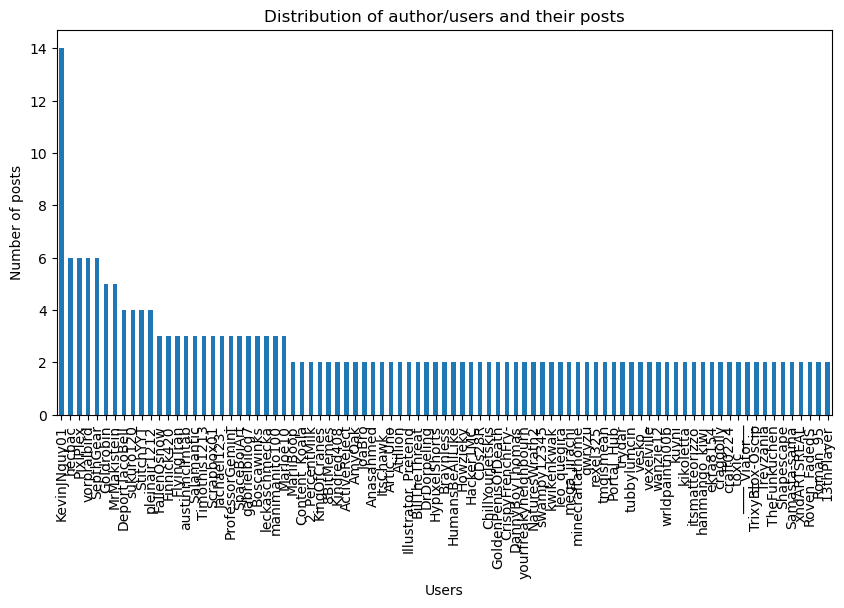

         id                author   score  subreddit
4    jkdp8n  yourfreakyneighbourh  124325  Minecraft
5    jn08ac  yourfreakyneighbourh   63708  Minecraft
12   io1pg4           xndARTSREAL   55922  Minecraft
13   kdbem3           xndARTSREAL   50315  Minecraft
19   jxs2pi         wrldpaintn00b   62422  Minecraft
..      ...                   ...     ...        ...
969  mf9l42             8BitMemes   46127  Minecraft
975  k79uk4         2_PercentMilk   77379  Minecraft
976  j70uiv         2_PercentMilk   56317  Minecraft
979  bkpl11            13thPlayer  129011  Minecraft
980  diuk5y            13thPlayer   51640  Minecraft

[231 rows x 4 columns]


In [56]:
top_authors = get_subreddit_top_authors('Minecraft', n_posts = 2000, graph = True)

print(top_authors)

In [97]:
top_authors_list = top_authors['author'].unique()
#cleaning list from names that cause 403 error

array(['yourfreakyneighbourh', 'xndARTSREAL', 'wrldpaintn00b', 'wanzie12',
       'vorpralbird', 'vexelville', 'vesko_', 'tubbylumcin', 'trydar',
       'tmgismean', 'swampy12345', 'sukuro120', 'rexel325', 'qwryzu',
       'pleinair1212', 'minecraftathome', 'mega_jirachi', 'manimanito100',
       'leo_quegira', 'leckaschmecka', 'kwikenkwak', 'kuvni', 'kikoletta',
       'itsmatteorizzo', 'hecbac', 'hanmango_kiwi', 'gabrielbilog7',
       'ekra8154', 'craggolly', 'craft0224', 'austinmclrntab',
       '____toxic____', '__Viator__', 'TrixyBlox-Oscip', 'Treyzania',
       'Timothis1213', 'TheFunkuchen', 'StitchYYT', 'SpaceBoiArt',
       'Shapescape', 'SepthGear', 'Scrapbox01', 'Samasta-sama',
       'Salamantic', 'Roven_FadedS', 'Roman_95', 'ProfessorGemini',
       'Portal_Hub', 'PixlPlex', 'NaturesWrath2', 'MrMakistein',
       'Marloe10', 'MariiBoop', 'KingOfCranes', 'Kindred408',
       'KevinJNguy01', 'JoaBro', 'Jachael123_', 'ItsChawk_',
       'Illustrator_Pretend', 'HypixelShorts'

In [98]:
df_scrapped = scrap_celebrities(top_authors_list, 30)

         id  score             user_name     subreddit_name
0   jff51qu     26  yourfreakyneighbourh            Metroid
1   jfchdgk      9  yourfreakyneighbourh           nintendo
2   jf9i5ps     23  yourfreakyneighbourh            Metroid
3   jf8vjb0    104  yourfreakyneighbourh            Metroid
4   jf8uhco    205  yourfreakyneighbourh            Metroid
5   jee3j2m      4  yourfreakyneighbourh            Trachem
6   jd7awbd    193  yourfreakyneighbourh   FireEmblemHeroes
7   j5sswa6     25  yourfreakyneighbourh  wholesomeanimemes
8   j5rsdt7    176  yourfreakyneighbourh  wholesomeanimemes
9   j5ntl7s      2  yourfreakyneighbourh   FireEmblemHeroes
10  j4nh4ta     16  yourfreakyneighbourh  wholesomeanimemes
11  j3x46tt     31  yourfreakyneighbourh   FireEmblemHeroes
12  j3wqnon     27  yourfreakyneighbourh   FireEmblemHeroes
13  ix6enn7     51  yourfreakyneighbourh  SmashBrosUltimate
14  itowrfv      3  yourfreakyneighbourh         fireemblem
15  itowqon      2  yourfreakyneighbourh

         id  score user_name   subreddit_name
0   jg9xn4r      1    vesko_             btd6
1   jdd7918      4    vesko_        Minecraft
2   jb54pb0      0    vesko_             btd6
3   j5ahom4      3    vesko_  HypixelSkyblock
4   iyi2ezw      2    vesko_        PhoenixSC
5   iw2bpo1      3    vesko_         Terraria
6   ihdo1hd      2    vesko_     MurderDrones
7   igjlq7z      5    vesko_        furry_irl
8   idygqgk      5    vesko_            furry
9   ibh92z4      1    vesko_        Minecraft
10  ibh92bf      1    vesko_        Minecraft
11  ibf500c      1    vesko_        Minecraft
12  ibe3gxz      1    vesko_        Minecraft
13  ib8qros      1    vesko_  HypixelSkyblock
14  i3uh3y6      1    vesko_            place
15  hy8d6y5      1    vesko_        AskReddit
16  hxrxxjs      2    vesko_        AskReddit
17  hwrxyv3      3    vesko_        Minecraft
18  hwrxvuz      7    vesko_        Minecraft
19  hw75kzz      1    vesko_             btd6
20  htlyqjd      9    vesko_      

         id  score user_name     subreddit_name
0   jh7rsr0      1  rexel325    DigitalPainting
1   jdoz2pf      1  rexel325    StableDiffusion
2   jda413w      3  rexel325   ethicaldiffusion
3   jd9xvl4      2  rexel325   ethicaldiffusion
4   jd7eamn      3  rexel325   ethicaldiffusion
5   jbryzrq      5  rexel325          TheForest
6   jbrsbey      9  rexel325          TheForest
7   jagff7o      2  rexel325          TheForest
8   jae2i4p      4  rexel325          TheForest
9   jad0nhu     -9  rexel325          TheForest
10  jabv6h9     -2  rexel325          TheForest
11  jabv4zy    -18  rexel325          TheForest
12  ja9n4i9      0  rexel325          TheForest
13  ja9eg8l     -1  rexel325          TheForest
14  j6i2kzg      1  rexel325    StableDiffusion
15  j5zf9gc      2  rexel325           webtoons
16  j5xuzc9      1  rexel325    StableDiffusion
17  j5xn9x8      1  rexel325           webtoons
18  j5xn1ip      2  rexel325           webtoons
19  j5tbhyo      1  rexel325  AIArtistWo

         id  score    user_name         subreddit_name
0   jebjzzd     11  leo_quegira      StardustCrusaders
1   iymzx5q      6  leo_quegira                    SCP
2   iym90pa     20  leo_quegira                    SCP
3   iylrpx1    170  leo_quegira                    SCP
4   iylqwv3    199  leo_quegira                    SCP
5   iylpq2s     25  leo_quegira                    SCP
6   ipbewkc     10  leo_quegira                 pigeon
7   ijff6og      1  leo_quegira                    SCP
8   iip8cnv      1  leo_quegira            vexillology
9   ihx3vf1      2  leo_quegira                    SCP
10  ig8shgi      1  leo_quegira                    SCP
11  iet3oq1      5  leo_quegira                fakemon
12  iegfk7s      2  leo_quegira  vexillologycirclejerk
13  ie87nb2     43  leo_quegira  vexillologycirclejerk
14  ic3lu9u      3  leo_quegira           DramaticText
15  i8qk84u      1  leo_quegira                    SCP
16  i8qhv1r      2  leo_quegira                    SCP
17  i8d6hv

         id  score user_name subreddit_name
0   ivndmjk      2    hecbac       u_hecbac
1   iviezu5      1    hecbac       u_hecbac
2   iviev5v      2    hecbac       u_hecbac
3   ivieorb      1    hecbac       u_hecbac
4   if6l9r1      1    hecbac      Minecraft
5   if6iz1o      2    hecbac      Minecraft
6   if6ix5e      1    hecbac      Minecraft
7   if01ib9      4    hecbac      Minecraft
8   if01equ     13    hecbac      Minecraft
9   iezttcz      3    hecbac      Minecraft
10  ieztqbj      2    hecbac      Minecraft
11  ieztl1c      2    hecbac      Minecraft
12  ieztjha     10    hecbac      Minecraft
13  iezt9vm      7    hecbac      Minecraft
14  iezt8q9      4    hecbac      Minecraft
15  iezsz29      2    hecbac      Minecraft
16  iey9l9l      9    hecbac      Minecraft
17  hnsjate      2    hecbac      Minecraft
18  hmzl3eh      1    hecbac       u_hecbac
19  hmv7zun      1    hecbac       u_hecbac
20  hj2dda1      1    hecbac       u_hecbac
21  hff854a      2    hecbac    

         id  score       user_name         subreddit_name
0   jha5622     14  austinmclrntab       unpopularopinion
1   jh0pw22      9  austinmclrntab                   news
2   jgst17e     -5  austinmclrntab            singularity
3   jgsqpgv     -1  austinmclrntab            singularity
4   jgspiy4      3  austinmclrntab            singularity
5   jgn887i      2  austinmclrntab                  Kenya
6   jgn61lx      1  austinmclrntab                  Kenya
7   j3i944m      2  austinmclrntab                  Kenya
8   j3crmzz      2  austinmclrntab                  Kenya
9   j31e8ya      3  austinmclrntab       unpopularopinion
10  j2tn9jm      1  austinmclrntab                  Kenya
11  j2tn8b2      1  austinmclrntab                  Kenya
12  j2t3n8h      2  austinmclrntab            singularity
13  j2ss4bg      6  austinmclrntab            singularity
14  j2srlr9      9  austinmclrntab            singularity
15  j2sr2m9     11  austinmclrntab            singularity
16  j2spu9x   

         id  score     user_name     subreddit_name
0   jhjh9pu      1  TheFunkuchen  NoStupidQuestions
1   jhj4906      3  TheFunkuchen  NoStupidQuestions
2   jf6776y     26  TheFunkuchen  NoStupidQuestions
3   jey38hu      4  TheFunkuchen            ukraine
4   jenya50     21  TheFunkuchen    TwoXChromosomes
5   jefdrtv      1  TheFunkuchen       HistoryMemes
6   jdes7yq      3  TheFunkuchen    TwoXChromosomes
7   jdcog2x     13  TheFunkuchen  UkrainianConflict
8   jd81x71     12  TheFunkuchen               Bonn
9   jcph38p    521  TheFunkuchen          Minecraft
10  jcl9err      3  TheFunkuchen          Minecraft
11  jckoon5      0  TheFunkuchen            ukraine
12  jcg5y4y      3  TheFunkuchen    ProgrammerHumor
13  jcf8ei6      2  TheFunkuchen             movies
14  jcehg9a      7  TheFunkuchen              books
15  jcanyd1      2  TheFunkuchen          worldnews
16  jcabobw      2  TheFunkuchen  NoStupidQuestions
17  jc9k6ks      2  TheFunkuchen         Futurology
18  jc9iz4d 

         id  score   user_name    subreddit_name
0   jhkfpth      1  Salamantic            cubase
1   jhkdsjs      1  Salamantic            cubase
2   jh7uxsc      1  Salamantic            cubase
3   jfpg7co      1  Salamantic         NewTubers
4   jduphzb      1  Salamantic  PartneredYoutube
5   jdt27ju      1  Salamantic        admincraft
6   jcgn8vl     10  Salamantic              Hull
7   ja3amdt     10  Salamantic              Hull
8   j62ywhd      1  Salamantic      TheSilphRoad
9   j5uj0ie      6  Salamantic         NewTubers
10  j518b9u      5  Salamantic         starbound
11  j0wydun      2  Salamantic       classiccars
12  j0mchpm      1  Salamantic          CasualUK
13  j086x2m      2  Salamantic     PaulMcCartney
14  j03ef8y      1  Salamantic         NewTubers
15  izwf4y7      1  Salamantic  PartneredYoutube
16  izc54c5     29  Salamantic      needforspeed
17  iyn4p32      2  Salamantic         NewTubers
18  iyaqrcb      2  Salamantic      needforspeed
19  iyaqpz7      2  

         id  score      user_name   subreddit_name
0   ig61s5e      1  NaturesWrath2  Minecraftbuilds
1   icitgg5     10  NaturesWrath2        Minecraft
2   icie417      1  NaturesWrath2        Minecraft
3   gc9kxgx      4  NaturesWrath2  Minecraftbuilds
4   ftpt8q5      3  NaturesWrath2  Minecraftbuilds
5   f05dp96      2  NaturesWrath2        Minecraft
6   f04pwkl      1  NaturesWrath2        Minecraft
7   f04pon1      6  NaturesWrath2        Minecraft
8   f04pnub      4  NaturesWrath2        Minecraft
9   f04k0ju      2  NaturesWrath2        Minecraft
10  f04dvx6      2  NaturesWrath2        Minecraft
11  e3vrrk2      2  NaturesWrath2        Minecraft
12  e3vro7q      1  NaturesWrath2        Minecraft
13  e3vr8ry      1  NaturesWrath2        Minecraft
14  e1isvjx      2  NaturesWrath2        Minecraft
15  e15y8ti      3  NaturesWrath2        Minecraft
16  e15xfla      4  NaturesWrath2        Minecraft
         id  score    user_name subreddit_name
0   itzqozm      2  MrMakistein    

         id  score user_name         subreddit_name
0   jheoram     53    JoaBro     technicalminecraft
1   jgjiv6x     10    JoaBro             technology
2   jdr9w6p      3    JoaBro     technicalminecraft
3   jdoygy6      2    JoaBro     technicalminecraft
4   jbor0s9     -4    JoaBro          okbuddyretard
5   j6yfzpq      3    JoaBro     technicalminecraft
6   j5p75nw     25    JoaBro     technicalminecraft
7   j5d5d9f      5    JoaBro              u_sth2010
8   j4sl4c5      9    JoaBro  WhatsWrongWithYourDog
9   j3hlace      3    JoaBro     technicalminecraft
10  j31mfoy     10    JoaBro     technicalminecraft
11  j2tca95      2    JoaBro     technicalminecraft
12  j1z782f     92    JoaBro     technicalminecraft
13  j1j4q0w      3    JoaBro     technicalminecraft
14  j1htxdq      9    JoaBro            MemeEconomy
15  j1b48k6    -13    JoaBro       Gamingcirclejerk
16  j0zvaba      1    JoaBro     technicalminecraft
17  j0y3wuo     20    JoaBro     technicalminecraft
18  j0crxwk 

         id  score user_name      subreddit_name
0   jhjah96      1  Howzieky  Breath_of_the_Wild
1   jhjaf1v     15  Howzieky  Breath_of_the_Wild
2   jhfmo0n      3  Howzieky                tall
3   jhboxdm     11  Howzieky    TheLastAirbender
4   jhbonaz     14  Howzieky                tall
5   jh5vpyf     23  Howzieky       marvelstudios
6   jh22box      5  Howzieky            redstone
7   jgzctai      3  Howzieky         Technoblade
8   jgtjx4w      1  Howzieky      Showerthoughts
9   jgtgedl      2  Howzieky      Showerthoughts
10  jgtg2fa      1  Howzieky      Showerthoughts
11  jgtfveq     22  Howzieky   MinecraftCommands
12  jgs931f     -2  Howzieky      Showerthoughts
13  jgs05es    129  Howzieky   MinecraftCommands
14  jgk0c3n      1  Howzieky   MinecraftCommands
15  jgaldiv      5  Howzieky      Showerthoughts
16  jg935ph     13  Howzieky    TheLastAirbender
17  jg7bmay      1  Howzieky         revancedapp
18  jg3z988     17  Howzieky              shield
19  jg0r49q      1  

         id  score    user_name subreddit_name
0   izb5yx0      2  FallenQsnow      Minecraft
1   iz8am4a      1  FallenQsnow      Minecraft
2   iymjic9      1  FallenQsnow      Minecraft
3   ixpf5f4      2  FallenQsnow      Minecraft
4   ixpetu1      1  FallenQsnow      Minecraft
5   ixormvm      1  FallenQsnow      Minecraft
6   ixork3l      1  FallenQsnow      Minecraft
7   ixor7l2      1  FallenQsnow      Minecraft
8   ixor5yp      2  FallenQsnow      Minecraft
9   ixor3vq      1  FallenQsnow      Minecraft
10  ixoqxau      2  FallenQsnow      Minecraft
11  ixoqpc9      1  FallenQsnow      Minecraft
12  ixldgcq     15  FallenQsnow      Minecraft
13  gskp6g2      1  FallenQsnow      Minecraft
14  gskp4lg      1  FallenQsnow      Minecraft
15  gsk2z4c      1  FallenQsnow      Minecraft
16  gsk2ih0      1  FallenQsnow      Minecraft
17  gqws8df      1  FallenQsnow        valheim
18  gqrbo9g      1  FallenQsnow        valheim
19  gq60q6b      0  FallenQsnow        valheim
20  gq4t5oj  

         id  score         user_name subreddit_name
0   jagxxpo      2  ChillYourJetskis    houseplants
1   j6i0kad      2  ChillYourJetskis    houseplants
2   j0bdrbf      2  ChillYourJetskis    houseplants
3   ihsfgl5      5  ChillYourJetskis    houseplants
4   ihscmjk     12  ChillYourJetskis    houseplants
5   ihb5cfm      1  ChillYourJetskis    houseplants
6   ig4atbd      2  ChillYourJetskis         pothos
7   icqh736      4  ChillYourJetskis         pothos
8   icmb09p      1  ChillYourJetskis         pothos
9   icfy945      3  ChillYourJetskis         pothos
10  icfu6wb      3  ChillYourJetskis         pothos
11  fznpfoe      1  ChillYourJetskis      Minecraft
12  fyos931      2  ChillYourJetskis      Minecraft
13  fxnfhad      5  ChillYourJetskis      Minecraft
14  fwqueul     24  ChillYourJetskis      Minecraft
15  fsqlsh1      1  ChillYourJetskis      Minecraft
16  fsqlj0e      2  ChillYourJetskis      Minecraft
17  fsqla3z      1  ChillYourJetskis      Minecraft
18  fsql5qg 

         id  score  user_name        subreddit_name
0   jewr5hh      1  Anasahmed        Showerthoughts
1   j7kp4hf      1  Anasahmed              pakistan
2   j7eimaw     44  Anasahmed              pakistan
3   j75jxzw      2  Anasahmed  Genshin_Impact_Leaks
4   j727hgg     13  Anasahmed  Genshin_Impact_Leaks
5   j58rvul      1  Anasahmed  Genshin_Impact_Leaks
6   j544nlo      1  Anasahmed          CrappyDesign
7   j4fq6uq      1  Anasahmed      Genshin_Memepact
8   j4eq4a4      0  Anasahmed  Genshin_Impact_Leaks
9   j4epqxz      2  Anasahmed      Genshin_Memepact
10  j4epdsx     19  Anasahmed      Genshin_Memepact
11  j4ep3ot      2  Anasahmed      Genshin_Memepact
12  j41a6hi     17  Anasahmed  Genshin_Impact_Leaks
13  j2w9gd4      3  Anasahmed      Genshin_Memepact
14  j17eeh1      1  Anasahmed             AskReddit
15  iygczu9      1  Anasahmed             AskReddit
16  isn8os2      2  Anasahmed             PakGamers
17  ir9qgt8      1  Anasahmed             Minecraft
18  ir9q8ln 

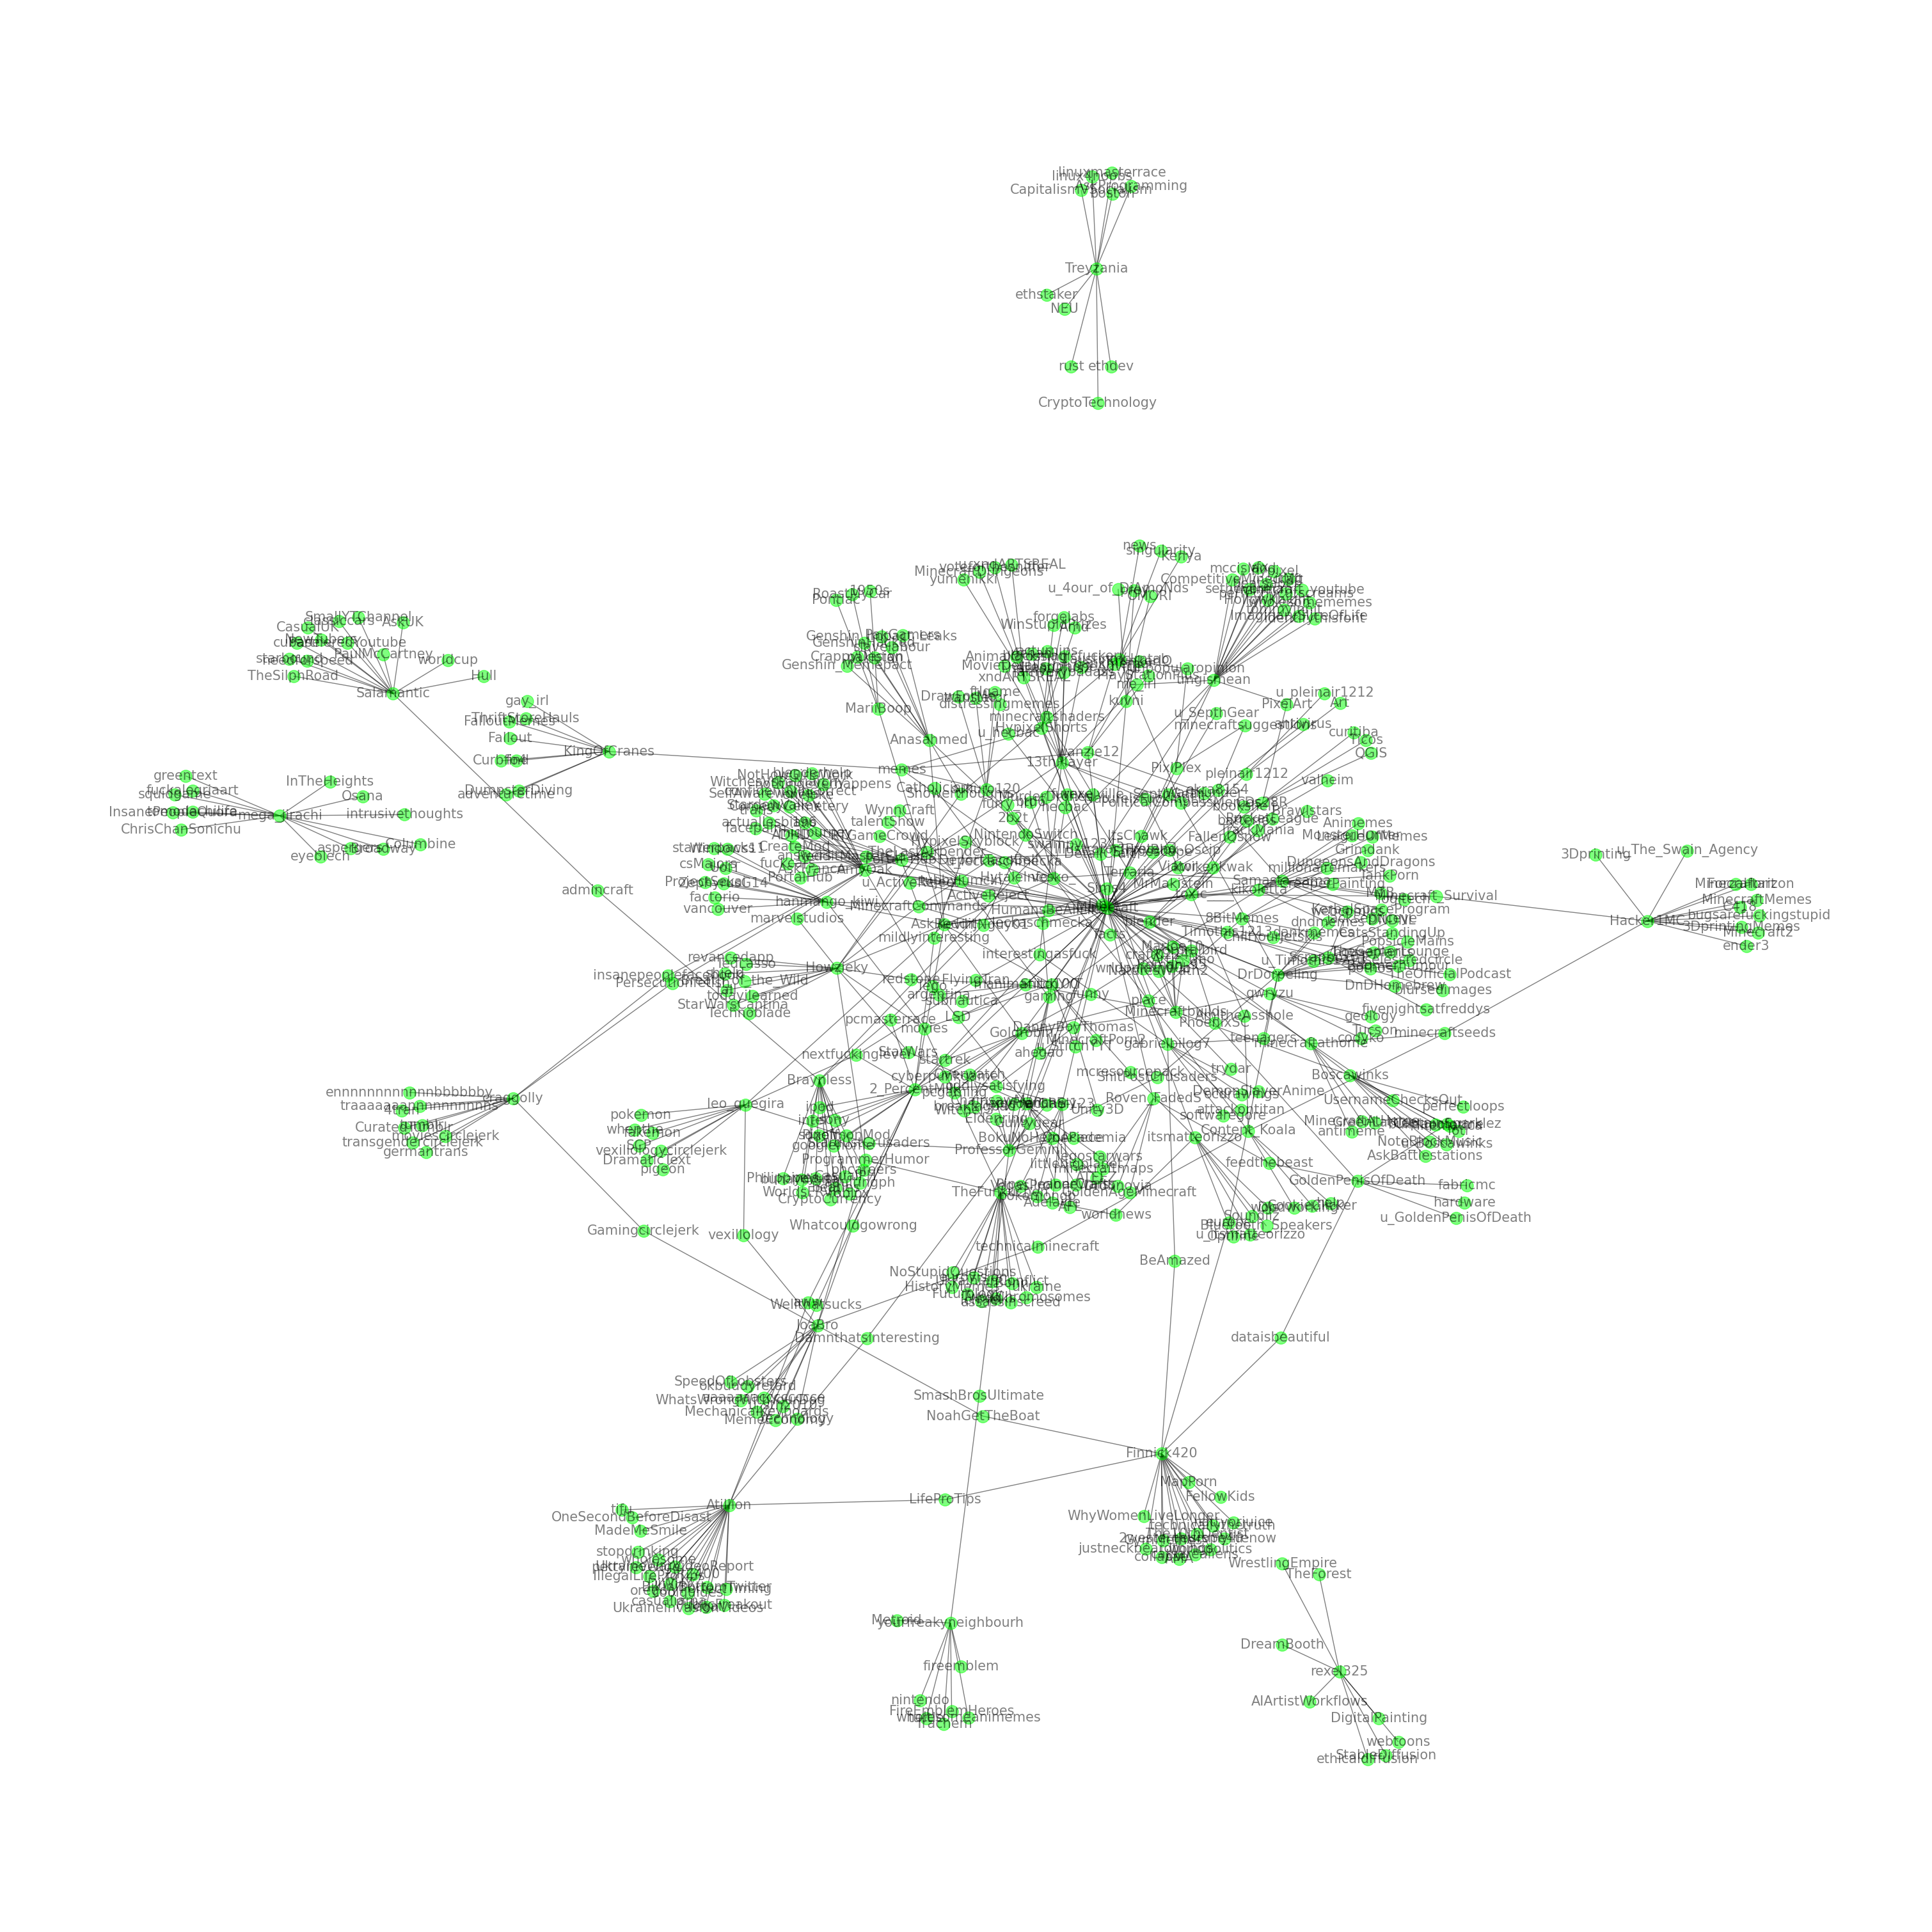

In [96]:
#to graph

df_scrapped['user_name'].nunique()
g = nx.from_pandas_edgelist(df_scrapped, source='user_name', target='subreddit_name')
    
graph_visual(g)

Max Degree of a Subreddits and Celebrities connections of Reddit r/minecraft = 62
Average Degree of a Subreddits and Celebrities connections of Reddit r/minecraft = 2.3578528827037775
Variance of a Degree destribution = 17.028998968416143
Top Celebrities:
[('Minecraft', 0.645), ('2_PercentMilk', 0.138), ('AmyOak', 0.094), ('ProfessorGemini', 0.091), ('Braynless', 0.09), ('tmgismean', 0.081), ('AskReddit', 0.08), ('Atillion', 0.07), ('pcmasterrace', 0.066), ('DrDorpeling', 0.063)]


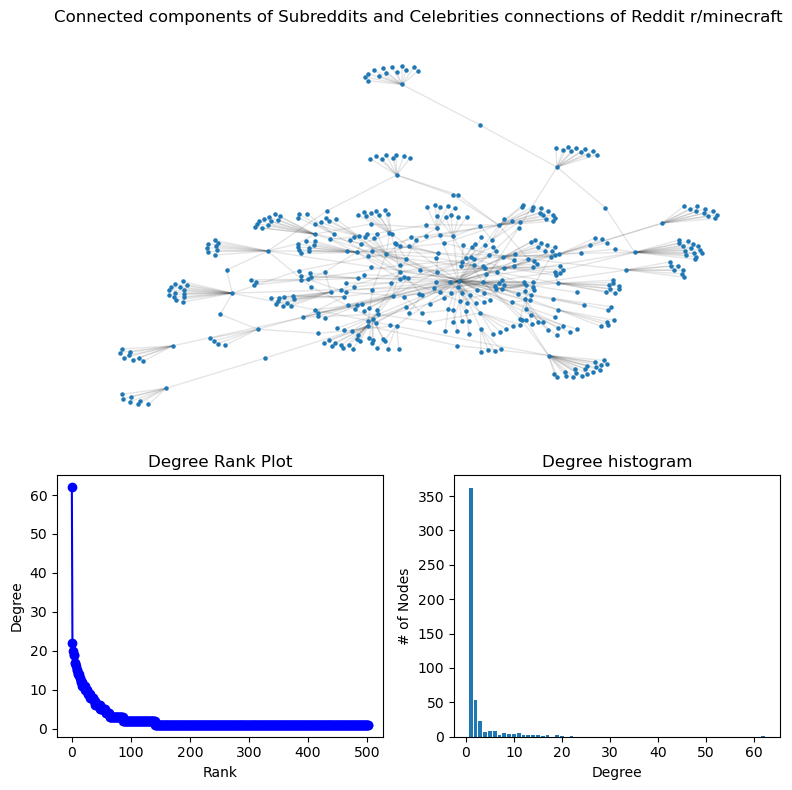

In [70]:
graph_distribution_info(g, 'Subreddits and Celebrities connections of Reddit r/minecraft')

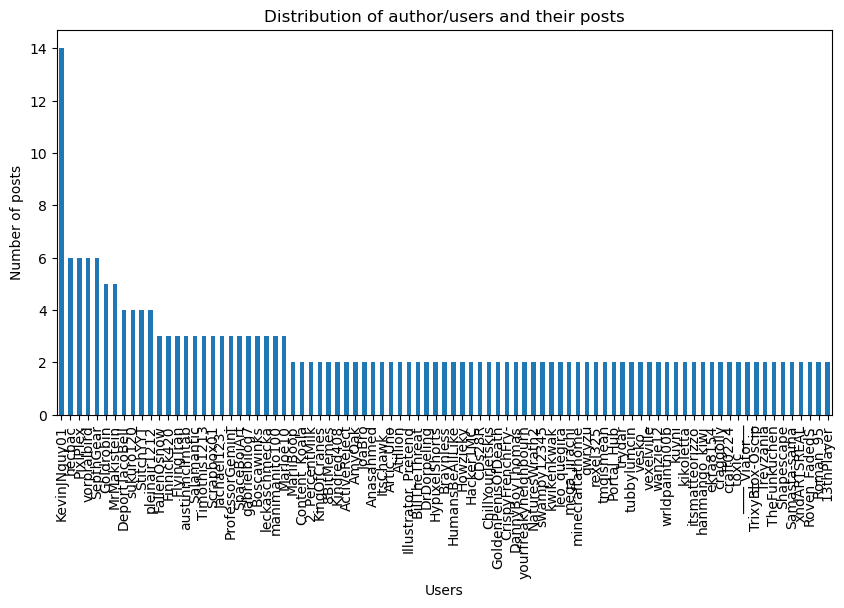

         id  score             user_name     subreddit_name
0   jff51qu     26  yourfreakyneighbourh            Metroid
1   jfchdgk      9  yourfreakyneighbourh           nintendo
2   jf9i5ps     24  yourfreakyneighbourh            Metroid
3   jf8vjb0    106  yourfreakyneighbourh            Metroid
4   jf8uhco    206  yourfreakyneighbourh            Metroid
5   jee3j2m      4  yourfreakyneighbourh            Trachem
6   jd7awbd    195  yourfreakyneighbourh   FireEmblemHeroes
7   j5sswa6     23  yourfreakyneighbourh  wholesomeanimemes
8   j5rsdt7    178  yourfreakyneighbourh  wholesomeanimemes
9   j5ntl7s      2  yourfreakyneighbourh   FireEmblemHeroes
10  j4nh4ta     16  yourfreakyneighbourh  wholesomeanimemes
11  j3x46tt     29  yourfreakyneighbourh   FireEmblemHeroes
12  j3wqnon     26  yourfreakyneighbourh   FireEmblemHeroes
13  ix6enn7     51  yourfreakyneighbourh  SmashBrosUltimate
14  itowrfv      3  yourfreakyneighbourh         fireemblem
15  itowqon      2  yourfreakyneighbourh

         id  score    user_name         subreddit_name
0   ig1yob7      1  vorpralbird              Minecraft
1   ig1yg9o      1  vorpralbird              Minecraft
2   ie01pci      2  vorpralbird              PhoenixSC
3   idzgped      1  vorpralbird              PhoenixSC
4   idzgntd      1  vorpralbird              PhoenixSC
5   idzglup      1  vorpralbird              PhoenixSC
6   idyqn0h      4  vorpralbird              Minecraft
7   idyqj82      3  vorpralbird              Minecraft
8   idy9tsf     50  vorpralbird              PhoenixSC
9   ibt0pfs      1  vorpralbird              Minecraft
10  ibsxe0x      2  vorpralbird              Minecraft
11  ibswrxc      1  vorpralbird              Minecraft
12  ibswida      1  vorpralbird              Minecraft
13  ibswggo      1  vorpralbird              Minecraft
14  ibswd9f      8  vorpralbird              Minecraft
15  ibswbrt      3  vorpralbird              Minecraft
16  ibsvtl9      2  vorpralbird              Minecraft
17  ibrheh

         id  score user_name   subreddit_name
0   jhk6y96      1    trydar  Minecraftbuilds
1   jhk6v9c      1    trydar  Minecraftbuilds
2   jhjtd3e      1    trydar  Minecraftbuilds
3   jhjtbj3      1    trydar  Minecraftbuilds
4   jhjtao8      1    trydar  Minecraftbuilds
5   jhjt8um      1    trydar  Minecraftbuilds
6   jhiz3kp      1    trydar  Minecraftbuilds
7   jhiyszc      1    trydar  Minecraftbuilds
8   jd73dzm      1    trydar  Minecraftbuilds
9   jd55mhk      1    trydar  Minecraftbuilds
10  jd54vgm      2    trydar  Minecraftbuilds
11  jd54rbh      1    trydar  Minecraftbuilds
12  jd3pry2      2    trydar  Minecraftbuilds
13  jd3lkiq      1    trydar  Minecraftbuilds
14  jd3lg4l      1    trydar  Minecraftbuilds
15  jd3lcbe      0    trydar  Minecraftbuilds
16  jcnl1xn      1    trydar  Minecraftbuilds
17  jcg8o1k      2    trydar  Minecraftbuilds
18  jcg8ne5      2    trydar  Minecraftbuilds
19  jcg8m4o      1    trydar  Minecraftbuilds
20  jcg8hja      1    trydar  Mine

         id  score user_name   subreddit_name
0   jhcv7o0      1    qwryzu           codyko
1   jhan8dp      3    qwryzu        Minecraft
2   jh5pcmt      1    qwryzu          geology
3   jgs6voj      2    qwryzu          geology
4   jgngj9k      6    qwryzu          geology
5   jgn03fe      4    qwryzu          geology
6   jg6uxtt     14    qwryzu          geology
7   jg6tntz      1    qwryzu          geology
8   jezjouw      2    qwryzu          geology
9   jejveo9      1    qwryzu          geology
10  je7el1j      3    qwryzu          geology
11  je5unxc     -2    qwryzu           Tucson
12  je337uq     13    qwryzu           Tucson
13  je2r92u      1    qwryzu          geology
14  jd4y9ti      1    qwryzu  Minecraftbuilds
15  jc379yf     16    qwryzu          geology
16  jc0jqoy      6    qwryzu           Tucson
17  jbhld3e     20    qwryzu           Tucson
18  jb7f9w4      1    qwryzu          geology
19  jakn8y8      1    qwryzu           Tucson
20  jai874d     15    qwryzu      

         id  score      user_name   subreddit_name
0   jf08okk      2  manimanito100       subnautica
1   j6vdavi      1  manimanito100        Minecraft
2   ivmu693      1  manimanito100        argentina
3   in55iy9      1  manimanito100         redstone
4   in0qx3w      1  manimanito100        Minecraft
5   in0qtjk      2  manimanito100              LSD
6   ilqvlg9     47  manimanito100        Minecraft
7   ikw2nrz      1  manimanito100        argentina
8   ige2c3f      2  manimanito100              LSD
9   igcpj3a      1  manimanito100        Minecraft
10  iftf9rj      1  manimanito100  Minecraftbuilds
11  idw0hsw      1  manimanito100        Minecraft
12  iah3q3o      1  manimanito100        Minecraft
13  iag70pm      2  manimanito100        Minecraft
14  iag6via      1  manimanito100        Minecraft
15  iag6ue6      2  manimanito100        Minecraft
16  iafwb2h      1  manimanito100        Minecraft
17  iafso3h     20  manimanito100        Minecraft
18  iafshv2      1  manimanito1

         id  score user_name      subreddit_name
0   jewgvww     10     kuvni               OMORI
1   jcwd4q2     75     kuvni                prey
2   hy3394s      2     kuvni               OMORI
3   hxgur0s      5     kuvni               OMORI
4   hxgtrng      7     kuvni               OMORI
5   hxgtncx      5     kuvni               OMORI
6   hx8uk7d      1     kuvni               OMORI
7   hvvuzal     20     kuvni               OMORI
8   hvuq3cg      8     kuvni               OMORI
9   hvlilsh      1     kuvni               OMORI
10  hvlc0z8      3     kuvni               OMORI
11  hvk3nmy      1     kuvni               OMORI
12  hvk2bts      3     kuvni               OMORI
13  hvk1rbt      5     kuvni               OMORI
14  hvjovm5     16     kuvni               OMORI
15  ho49ezm     16     kuvni               OMORI
16  hnp676k     12     kuvni               OMORI
17  hbrlonc      1     kuvni           Minecraft
18  hbr4q9l      5     kuvni           Minecraft
19  hbr4md0      4  

         id  score      user_name     subreddit_name
0   ih8uv5b      1  gabrielbilog7          teenagers
1   ih8slxt      1  gabrielbilog7          teenagers
2   ih8sfb4      1  gabrielbilog7          teenagers
3   ih8rmvr      3  gabrielbilog7          teenagers
4   ih8rio0      1  gabrielbilog7          teenagers
5   i7rrl0b      1  gabrielbilog7  interestingasfuck
6   i0mjt77      1  gabrielbilog7           BeAmazed
7   i0f4pvu      1  gabrielbilog7          teenagers
8   i0cgauu      1  gabrielbilog7        DetailCraft
9   hzt4d89      4  gabrielbilog7         ocdrawings
10  hyfswmt     93  gabrielbilog7           BeAmazed
11  hx6dmia      1  gabrielbilog7          teenagers
12  hwxqko0     31  gabrielbilog7   DemonSlayerAnime
13  hwmqe30      1  gabrielbilog7          teenagers
14  hwk9aqm      4  gabrielbilog7        DetailCraft
15  hw847pe      1  gabrielbilog7           BeAmazed
16  hvynzyj     90  gabrielbilog7        DetailCraft
17  hvso5h0     44  gabrielbilog7       softwa

         id  score      user_name      subreddit_name
0   jh2juuv      7  ____toxic____              gaming
1   jh2h35c      7  ____toxic____              gaming
2   jgwtql5      1  ____toxic____           AskReddit
3   jf1pd66      1  ____toxic____          TrackMania
4   jdf8aoz      1  ____toxic____  NatureIsFuckingLit
5   jd3b88x      1  ____toxic____           AskReddit
6   jbm5gfd      1  ____toxic____       AmItheAsshole
7   jbm51kh      8  ____toxic____       AmItheAsshole
8   jatzl7y      1  ____toxic____        RocketLeague
9   j9l3hnf      1  ____toxic____           AskReddit
10  j9f1fiv      1  ____toxic____        RocketLeague
11  j7bbgas      2  ____toxic____          TrackMania
12  j7ba5kk      1  ____toxic____          TrackMania
13  j7b9h8u      1  ____toxic____          TrackMania
14  j7b916u      1  ____toxic____          TrackMania
15  j795oow     13  ____toxic____  Minecraft_Survival
16  j5r4mgn      1  ____toxic____           Minecraft
17  j5qxk1r      1  ____toxi

         id  score     user_name     subreddit_name
0   jhjh9pu      1  TheFunkuchen  NoStupidQuestions
1   jhj4906      3  TheFunkuchen  NoStupidQuestions
2   jf6776y     28  TheFunkuchen  NoStupidQuestions
3   jey38hu      4  TheFunkuchen            ukraine
4   jenya50     21  TheFunkuchen    TwoXChromosomes
5   jefdrtv      1  TheFunkuchen       HistoryMemes
6   jdes7yq      5  TheFunkuchen    TwoXChromosomes
7   jdcog2x     12  TheFunkuchen  UkrainianConflict
8   jd81x71     11  TheFunkuchen               Bonn
9   jcph38p    526  TheFunkuchen          Minecraft
10  jcl9err      3  TheFunkuchen          Minecraft
11  jckoon5      0  TheFunkuchen            ukraine
12  jcg5y4y      4  TheFunkuchen    ProgrammerHumor
13  jcf8ei6      4  TheFunkuchen             movies
14  jcehg9a     10  TheFunkuchen              books
15  jcanyd1      2  TheFunkuchen          worldnews
16  jcabobw      2  TheFunkuchen  NoStupidQuestions
17  jc9k6ks      2  TheFunkuchen         Futurology
18  jc9iz4d 

         id  score     user_name      subreddit_name
0   ir4znzs      1  Samasta-sama            logitech
1   gws96m0      2  Samasta-sama            Terraria
2   gksgaob      2  Samasta-sama          Warthunder
3   gksfsq7      1  Samasta-sama          Warthunder
4   gkqdl0w     38  Samasta-sama          Warthunder
5   gkqd66o      4  Samasta-sama          Warthunder
6   g8pq11g      3  Samasta-sama          Warthunder
7   g8ppy1a      3  Samasta-sama          Warthunder
8   g8pljlj      2  Samasta-sama          Warthunder
9   g8p6zl5      4  Samasta-sama          Warthunder
10  g6njv1u      4  Samasta-sama            TankPorn
11  g6jietj      6  Samasta-sama            TankPorn
12  g5jpsn6      1  Samasta-sama       jacksepticeye
13  g5bisc4      3  Samasta-sama                 MTB
14  g42v5y5      1  Samasta-sama           Minecraft
15  g40e424      3  Samasta-sama           Minecraft
16  g2w2f9n      1  Samasta-sama       jacksepticeye
17  g2w27rw      2  Samasta-sama       jacksep

         id  score        user_name        subreddit_name
0   jfvezfl      6  ProfessorGemini                u_GRS-
1   jfl8fxl      4  ProfessorGemini             Eldenring
2   jbz57xe      1  ProfessorGemini             Eldenring
3   j6nlw79     65  ProfessorGemini           ChainsawMan
4   j44wi3c      1  ProfessorGemini             Eldenring
5   j3sfnih      2  ProfessorGemini             Eldenring
6   ijexzy6      0  ProfessorGemini                gaming
7   ijexwbc      2  ProfessorGemini                 xqcow
8   iifnh39     11  ProfessorGemini     SmashBrosUltimate
9   ifn3lls      2  ProfessorGemini  Damnthatsinteresting
10  iezoe6d      3  ProfessorGemini                 xqcow
11  i0ncp6r      1  ProfessorGemini           breakingbad
12  hyjoiwh     18  ProfessorGemini                 xqcow
13  heg5m69    213  ProfessorGemini              OnePiece
14  h2v5fl4     28  ProfessorGemini                gaming
15  h258rss      2  ProfessorGemini            Guiltygear
16  gzho2gp   

In [ ]:
authors = get_subreddit_top_authors('Minecraft', n_posts = 10000, graph = True)
authors_list = authors['author'].unique()
dataframe_celebrities = scrap_celebrities(authors_list, 40)

In [ ]:
dataframe_celebrities['user_name'].nunique()
g = nx.from_pandas_edgelist(dataframe_celebrities, source='user_name', target='subreddit_name')

graph_visual(g, no_it = 250, k_val = 0.2)

In [ ]:
graph_distribution_info(g, 'r/Minecraft')